
# More General Boundary Conditions
So far we have used Dirichlet and trivial Neumann boundary conditions. Here we discuss how to
impose other conditions like general Neumann, Robin and more general
Dirichlet conditions. We will show how to add these to the model and how to
prescribe different conditions for different components of the solution
in the case of vector valued PDEs.

## Dirichlet boundary conditions
.. index::
   pair: Boundary; Dirichlet

To fix Dirichlet boundary conditions $u=g$ on part of the boundary
$\Gamma\subset\partial\Omega$ the central class is
`dune.ufl.DirichletBC` which takes three arguments:
the discrete function space for $u$, the function $g$ given by a UFL
expression, and a description of $\Gamma$. There are different ways to
do this. If the final argument is omitted or `None` the condition is applied to the whole
domain, a integer $s>0$ can be provided which can be set to describe a
part of the boundary during grid construction as described at the end of
this section. Finally a UFL condition can be used, i.e., `x[0]<0`.

For vector valued functions $u$ the value function $g$ can be a UFL
vector or a list. In the later case a component of `None` can be used to
describe components which are not to be constrained by the boundary
condition.

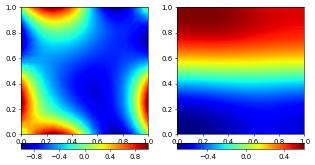

In [1]:
from matplotlib import ticker
from dune.fem.plotting import plotComponents

import numpy, io
from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem.function import gridFunction
from dune.ufl import DirichletBC, Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate,\
                dx, ds, grad, inner, sin, pi

gridView = leafGridView([0, 0], [1, 1], [4, 4])
vecSpace = solutionSpace(gridView, dimRange=2, order=2)
x = SpatialCoordinate(vecSpace)
vec = vecSpace.interpolate([0,0], name='u_h')
uVec,vVec = TrialFunction(vecSpace), TestFunction(vecSpace)
a  = inner(grad(uVec), grad(vVec)) * dx
a += ( ( 10*(1-2*uVec[1])+uVec[0] ) * vVec[0] +\
       ( 10*sin(2*pi*x[1]) + (1-2*uVec[0])**2*uVec[1] ) * vVec[1]
     ) * dx

# Define Dirichlet boundary conditions for first component on all boundaries
bc = DirichletBC(vecSpace,[sin(2*pi*(x[0]+x[1])),None])
vecScheme = solutionScheme( [a == 0, bc],
        parameters={"linear.tolerance": 1e-9} )

vecScheme.solve(target=vec)

plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})

To prescribe $u_2=1$ at the bottom boundary is easily achieve by
providing multiple instances of the `dune.ufl.DiricheltBC` class:

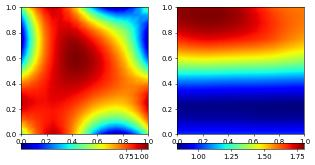

In [2]:
bcBottom = DirichletBC(vecSpace,[sin(2*pi*(x[0]+x[1])),1],x[1]<1e-10)
vecScheme = solutionScheme( [a == 0, bc, bcBottom],
        parameters={"linear.tolerance": 1e-9} )
vecScheme.solve(target=vec)
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})

We can also use general grid functions (including discrete functions)
for the boundary conditions in the same way we could use grid functions
anywhere within the UFL forms.
We could for example fix the boundary values of the first component using the discrete solution
from the previous computation by writing
`bc = DirichletBC(vecSpace,[vec[0],None])`
Since this would just be an approximation to the actual boundary
condition the overall results would not be identical to the previous
version. We therefore do not use the discrete solution to describe the
boundary conditions but instead use other forms of grid functions.
The following two code snippets lead to the same results as above:

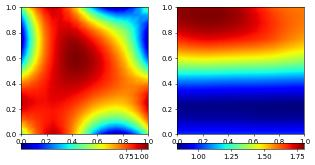

In [3]:
test = vec.copy()
test.clear()
@gridFunction(gridView ,name="bnd",order=2)
def bnd(x):
    return [numpy.sin(2*numpy.pi*(x[0]+x[1])),1]
bcBottom = DirichletBC(vecSpace,bnd,x[1]<1e-10)
vecScheme = solutionScheme( [a == 0, bc, bcBottom],
        parameters={"linear.tolerance": 1e-9} )
vecScheme.solve(target=test)
plotComponents(test, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})
assert sum([ abs(td-vd) for td,vd in zip(test.dofVector, vec.dofVector)] ) /\
       len(vec.dofVector) < 1e-8

As with other grid functions we can also use
[C++ code snippets](cppfunctions_nb.ipynb).
to define the Dirichlet conditions.

.. index::
   triple: Boundary; Dirichlet; Degrees of Freedom

## Accessing the Dirichlet degrees of freedom

We provide a few methods to apply or otherwise access information about
the Dirichlet constraints from an existing scheme.

The following shows how to set all degrees of freedom on the Dirichlet
boundary to zero. For a more realistic example see the second approach in
the section on
[solving Dirichlet Eigenvalue problems](evalues_laplace_nb.ipynb#Dirichlet-Eigenvalue-problem).

In [4]:
for i in vecScheme.dirichletIndices():
    vec.dofVector[i] = 0

.. tip:: The `dirichletIndices` method takes as optional argument an `id`
   which then returns the list of indices of degrees of freedom on the
   boundary with that id. See further down for a discussion on boundary ids.

We have set all degrees of freedom on the boundary to zero. In this
example the Dirichlet boundary was specified by the two `DirichletBC`
instances `bc` and `bcBottom`. The first specified that for the
first component the whole boundary was Dirichlet while specifying nothing
for the second component. The second then set Dirichlet conditions for
the second component along the lower boundary. Consequently, the solution
should now be zero along the whole boundary in the first component, and
zero along the lower boundary for the second:

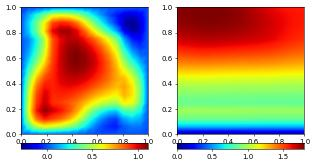

In [5]:
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})

.. index::
   triple: Boundary; Dirichlet; Setting Constraints

It is sometimes necessary to set all degrees of freedom on the boundary
to zero, to be equal to some other function, or to as an interpolation of
the boundary data provided to the scheme.
To this end the operators/schemes
provide methods `setConstraints`. To cover the cases detailed above,
there are three versions of this method:

1. the first takes a discrete function and sets the Dirichlet dofs
   to the boundary data provided in the `DirichletBC` structure.
2. The second version takes a range vector and a discrete function;
   this version can used for example to set the values at the boundary to
   zero, e.g., `op.setConstraints(0, uh)` or for a vector
   function `op.setConstraints([0,]*space.dimension, vec_h)`.
3. Finally there is a version taking a grid function and a
   discrete function `op.setConstraints(g, uh)` which sets
   the dofs at the boundary so that `uh=g` at the Dirichlet boundary.

We use the first version to set the data at the boundary first having
cleared the discrete function. As second
example we interpolate the `bnd` grid function and then set all
boundary dofs to 0. Recall that the second component has no Dirichlet
boundary conditions set at the lower boundary.

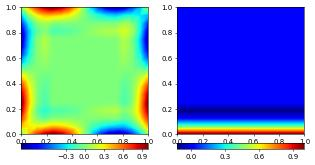

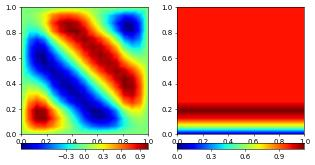

In [6]:
vec.clear()
vecScheme.setConstraints(vec)
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})
vec.interpolate(bnd)
vecScheme.setConstraints([0,]*len(vec), vec)
plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})

.. index::
   pair: Boundary; Neumann

## Neumann and Robin boundary conditions

Neumann boundary flux are added to the ufl form by using the measure `ufl.ds`.
By default they will be added to all boundaries for which no Dirichlet
conditions have been prescribed. In the above example we prescribed no
Dirichlet conditions to the second component at both vertical
and the top boundary using the `dune.ufl.DirichletBC` instance `bc`.
This leads to zero fluxes (natural boundary conditions) being used there.
To add some (here nonlinear) Neumann boundary conditions for the second
component at these three sides we can simply add an additional term to
`a`:

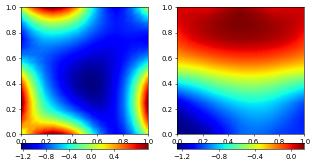

In [7]:
a  = a + uVec[0]*uVec[0] * vVec[1] * ds
vecScheme = solutionScheme( [a == 0, bc],
        parameters={"linear.tolerance": 1e-9} )

vecScheme.solve(target=vec)

plotComponents(vec, gridLines=None, level=2,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})

Robin boundary conditions can be handled in the same way using
the `ufl.ds` measure.

.. index:
   triple: Boundary; Dirichlet; Boundary Identifiers (ids)

## Using boundary ids (and some more complex examples)

Up until now we have used UFL boolean expressions to
define the subset of the boundary where a Dirichlet condition should be
applied. In many cases different parts of the boundary are already marked
with ids (integers) during grid construction. These ids can also be used
to define where boundary conditions are to be applied.
At the moment to use boundary ids the grid has to be constructed using
the Dune Grid Format (dgf) reader. Please consult the [documentation of the
DGF file format](https://dune-project.org/doxygen/master/group__DuneGridFormatParser.html#details) for details
and [other examples given for grid construction](othergrids_nb.ipynb).

.. index::
   triple: Boundary; Dirichlet; Cartesian Boundary Ids

### Cartesian boundary ids

For Cartesian grids the boundary ids are rather fixed and pre-described due to
implementation specifics. The numbering of the boundary edges follows the numbering of
faces of the [DUNE reference elements](https://dune-project.org/doxygen/master/group__GeometryReferenceElements.html#details)
but starts from 1. For example, in 2d the boundary ids are
`left=1`, `right=2`, `bottom=3`, `top=4` and in 3d `bottom=5`, `top=6`.
For grids implementing a true
Cartesian grids, like YaspGrid, this is fixed. Altering this numbering
can only be done by using an unstructured grid, e.g. ALUGrid.
See the [grid construction section](othergrids_nb.ipynb#Attaching-boundary-ids-to-a-grid-constructed-with-gmsh-using-DGF) to get an idea how this is done.

.. note:: **Boundary ids and refinement**: Boundary ids only allow to tell apart intersections with the domain boundary
on the macro level of a grid. Descendants of macro intersections on the domain
boundary inherit the boundary id of their parent.


.. index::
   pair: Boundary; Robin

### Mixing different types of boundary conditions

These ids can be used as third argument in the `DirichletBC` constructor
and also in the boundary measure `ufl.ds` as shown in the following
examples solving a Laplace problem with a combination of **Neumann**, **Robin**, and
**Dirichlet** boundary conditions.

In this example the boundary conditions are

- left and right boundary (id=1 and id=2):
  Robin boundary conditions $\nabla u\cdot n + u = -10$ for $y\in[0.4,0.6]$ and
  natural boundary conditions ($\nabla u\cdot n=0$) otherwise.
- bottom boundary (id=3):
  Neumann conditions $\nabla u\cdot n=2$
- top boundary (id=4):
  Dirichlet conditions $u=1$ for $x\in [0.3,0.6]$ and
  natural boundary conditions ($\nabla u\cdot n=0$) otherwise.

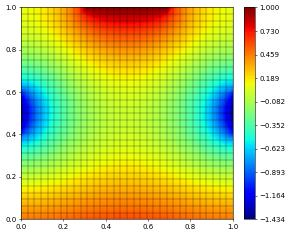

In [8]:
from dune.ufl import BoundaryId
from ufl import ds, grad, dot, inner, conditional, eq, And, FacetNormal, Not

gridView.hierarchicalGrid.globalRefine(3)
space = solutionSpace(gridView, order=2)
x,n = SpatialCoordinate(space), FacetNormal(space)
u,v = TrialFunction(space), TestFunction(space)
a  = inner(grad(u), grad(v)) * dx

fbnd  = (u-10 * v *                    # middle of left and right boundary
         conditional(abs(x[1]-0.5)<0.1,1,0) ) * ds( (1,2) )
fbnd += 2 * v * ds(3)                  # bottom boundary
dbc   = DirichletBC(space, 1,          # middle of top boundary
           And( eq(BoundaryId(space),4), abs(x[0]-0.5)<0.2 ))

scheme   = solutionScheme( [a == fbnd, dbc] )
solution = space.interpolate(0, name='u_h')
scheme.solve(target=solution)
solution.plot()

The final example has a slightly more complex setup at the boundary:

- left and right (id=1 and id=2):
  for $y\in[0.4,0.6]$ we set Neumann conditions $\nabla u\cdot n=-50$
- left and right (id=1 and id=2):
  for $y\in[0.2,0.8]\setminus [0.4,0.6]$ we set Dirichlet conditions $u=1$
- rest of boundary: 3

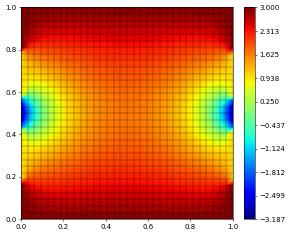

In [9]:
fbnd  = (-50 * v *                     # middle of left and right boundary
         conditional(abs(x[1]-0.5)<0.1,1,0) ) * ds( (1,2) )
dbc   = [ DirichletBC(space, 1,        # not middle of left and right boundary
            And( And( BoundaryId(space)<=2,
                 abs(x[1]-0.5)>0.1 ), abs(x[1]-0.5)<0.3 ) ),
          DirichletBC(space, 3,        # not middle of left and right boundary
            Not( And(BoundaryId(space)<=2,abs(x[1]-0.5)<0.3) ) ), ]

scheme   = solutionScheme( [a == fbnd, *dbc] )
solution = space.interpolate(0, name='u_h')
scheme.solve(target=solution)
solution.plot()

Let check if that solution makes sense...

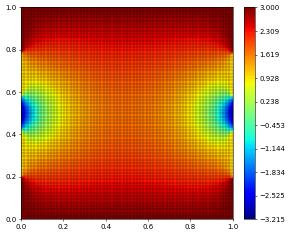

In [10]:
gridView.hierarchicalGrid.globalRefine(1)
scheme.solve(target=solution)
solution.plot()